In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
from sklearn.datasets import load_wine
from scipy.cluster.vq import kmeans2, whiten
from collections import Counter

conn = sqlite3.connect("dinofunworld.db")
c = conn.cursor()

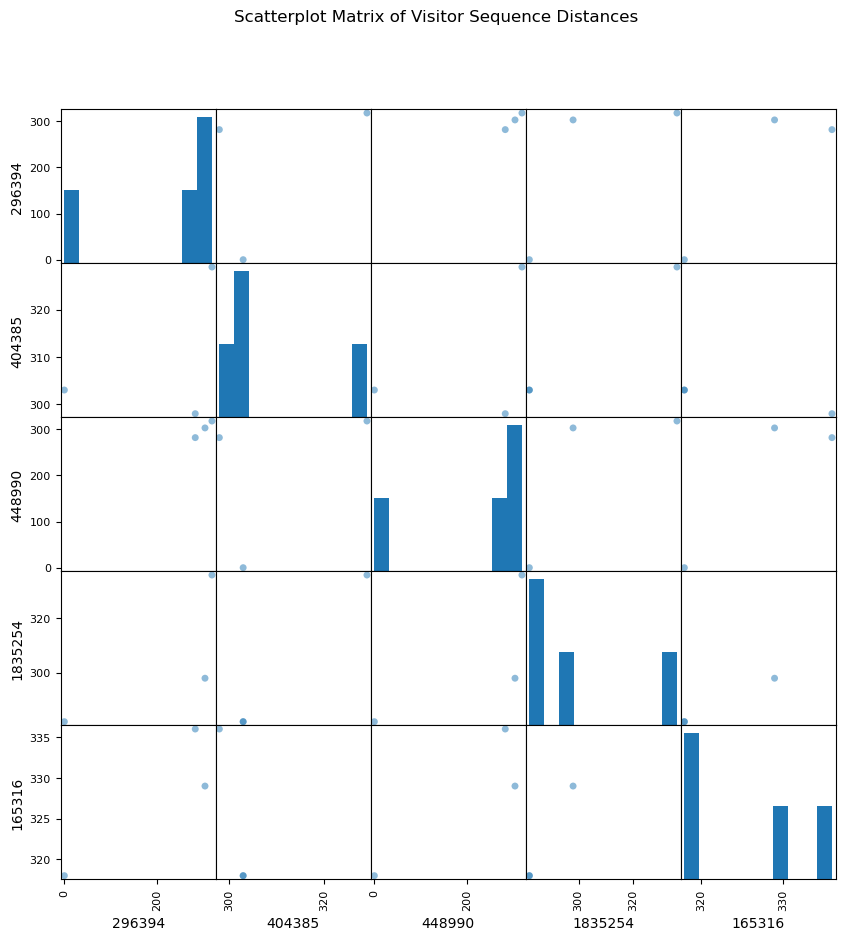

In [2]:
#To visualize visitor behavior patterns, 
#I computed a distance matrix for five 
#selected visitors based on the number of 
#dissimilarities in their check-in sequences, 
#preparing the data for hierarchical clustering.
#Visitors 296394 and 448990 are together.

Ids = [165316, 1835254, 296394, 404385, 448990]

placeholders = ",".join("?" for _ in Ids)

query = f"""
SELECT c.visitorID, s.sequence
FROM checkin c
JOIN sequences s ON c.visitorID = s.VisitorID
WHERE c.visitorID IN ({placeholders})
GROUP BY c.visitorID, s.sequence;
"""

c.execute(query, Ids)
H = c.fetchall()

Results = {}

H = [
    (visitor_id, sequence.split("-"))
    for visitor_id, sequence in H
]

for Visitor_ID, Visitor in H:
    temp = {}
    for Visitor2_ID, Visitor2 in H:
        if Visitor2_ID == Visitor_ID:
            continue
        counter = 0
        for i in range(min(len(Visitor), len(Visitor2))):
            if Visitor[i] != Visitor2[i]:
                counter+=1
        temp.update({Visitor2_ID: counter})
                    
    Results.update({Visitor_ID: temp})


from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(Results, orient='index')
scatter_matrix(df, figsize=(10, 10), diagonal='hist', s=100)
plt.suptitle("Scatterplot Matrix of Visitor Sequence Distances")
plt.show()

#print(Results)

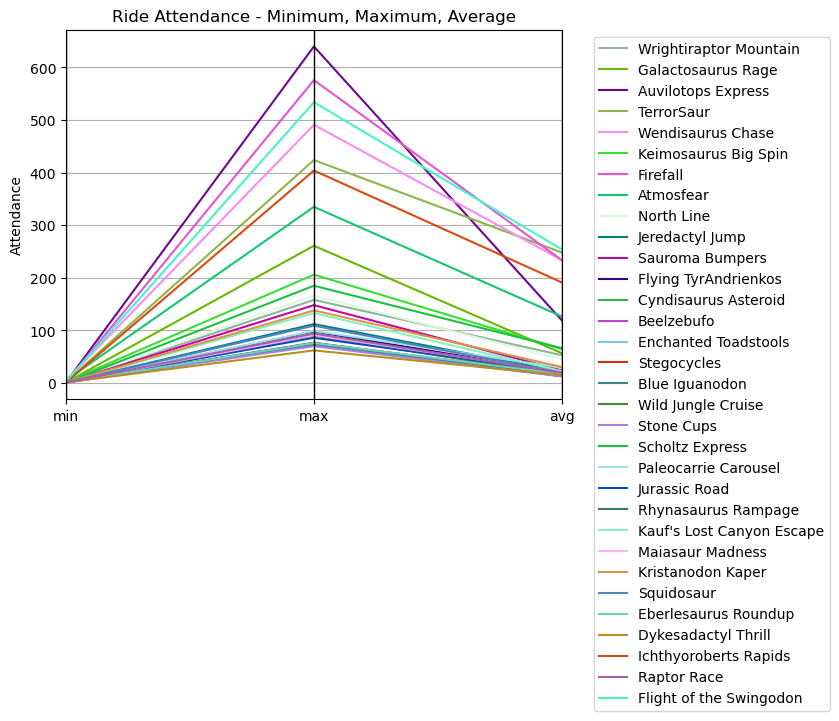

In [3]:
#To show and compare attendance patterns across rides in the park, 
#I created a Parallel Coordinate Plot showing the minimum, 
#maximum, and average attendance for each ride.

c.execute("""
    SELECT AttractionID, Name
    FROM attraction
    WHERE Category LIKE '%ride%';
""")
attractions = c.fetchall()

c.execute("""
    SELECT visitorID, sequence
    FROM sequences;
""")

sequences = c.fetchall()
sequences_df = pd.DataFrame(sequences, columns=["visitorID", "sequence"])
sequence_dict = {attraction_id: Counter() for attraction_id, _ in attractions}
seq_len = sequences_df['sequence'].apply(lambda s: len(s.split('-'))).max()

for _, row in sequences_df.iterrows():
    seq = row['sequence'].split('-')
    
    for i, val in enumerate(seq):
        val = int(val) 
        
        if val not in sequence_dict:
            continue

        sequence_dict[val][i] += 1
        
attendance = {}
ride_name_dict = dict(attractions)


for ride, time_counts in sequence_dict.items():
    counts = [time_counts.get(pos, 0) for pos in range(seq_len)]
    avg = np.mean(counts)
    avg = round(avg, 6)
    non_zero_counts = [c for c in counts if c > 0]
    attendance[ride_name_dict[ride]] = {        
        "min": min(non_zero_counts),
        "max": max(counts),
        "avg": sum(counts)/len(counts)
    }

df = pd.DataFrame.from_dict(attendance, orient="index")
df["Ride"] = df.index
df = df[["Ride", "min", "max", "avg"]]
df.reset_index(drop=True, inplace=True)

pd.plotting.parallel_coordinates(
    df,
    class_column="Ride"
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylabel("Attendance")
plt.title("Ride Attendance - Minimum, Maximum, Average")
plt.show()

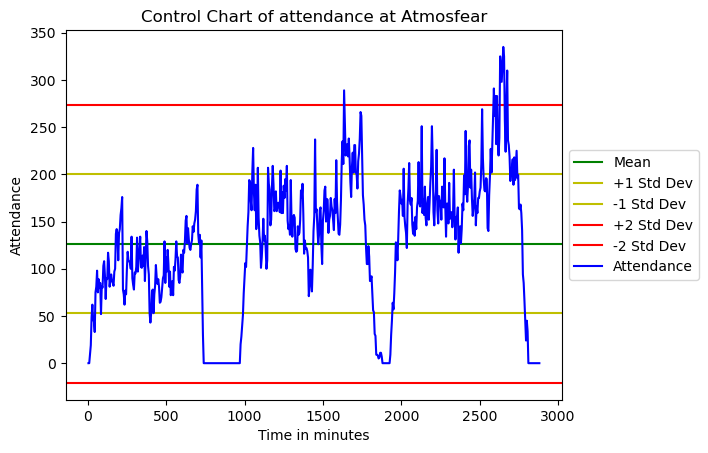

In [4]:
#I developed a statistical control chart for Atmosfear attendance, 
#visualizing the process mean and ±1σ and ±2σ boundaries to identify 
#potential deviations from typical operating behavior.


query = "SELECT visitorID, sequence FROM sequences;"
df = pd.read_sql(query, conn)
Atmosfear_ID = '8'

times = [0]*576

for index, row in df.iterrows():
    visitor = row['visitorID']
    seq = row['sequence'].split('-')
    
    for i, val in enumerate(seq):
        if val == Atmosfear_ID:
            times[i] += 1

Attendance_at_time = [i * 5 for i in range(1, len(times) + 1)]

avg = np.mean(times)
std = np.std(times)

plt.axhline(avg, color='g', linestyle='-', label='Mean')
plt.axhline(avg + std, color='y', linestyle='-', label='+1 Std Dev')
plt.axhline(avg - std, color='y', linestyle='-', label='-1 Std Dev')
plt.axhline(avg + 2*std, color='r', linestyle='-', label='+2 Std Dev')
plt.axhline(avg - 2*std, color='r', linestyle='-', label='-2 Std Dev')

plt.plot(Attendance_at_time, times, 'b-', label='Attendance')

plt.xlabel('Time in minutes')
plt.ylabel('Attendance')
plt.title('Control Chart of attendance at Atmosfear')

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

plt.show()
#print([float(avg), float(std)])

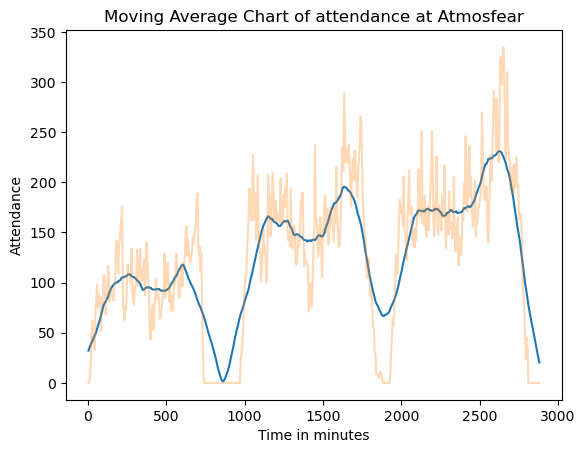

In [8]:
#To demonstrate underlying attendance trends at Atmosfear, 
#I computed a 50-period moving average to smooth short-term 
#fluctuations and highlight longer-term patterns.

times = np.array(times)
window = np.ones(50) / 50
moving_avg = np.convolve(times, window, mode='same')
times_series = pd.Series(times)

plt.plot(Attendance_at_time, moving_avg)

plt.plot(Attendance_at_time, times_series, alpha=0.3, label="Raw Attendance")

plt.xlabel('Time in minutes')
plt.ylabel('Attendance')
plt.title('Moving Average Chart of attendance at Atmosfear')
plt.show()

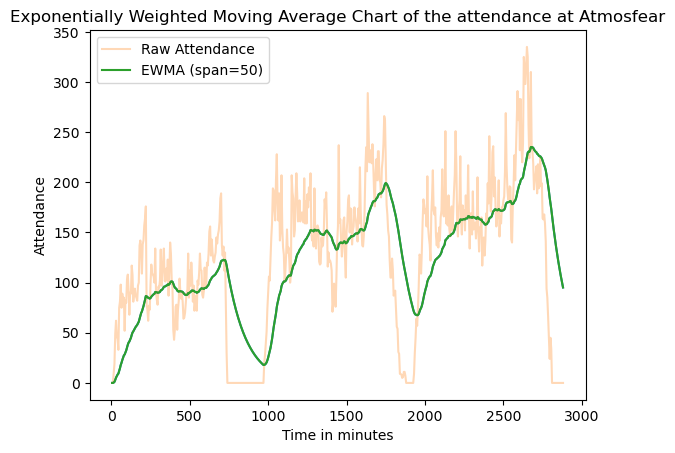

In [7]:
#An exponentially weighted moving average chart for the attendance of Atmosfear. 
#To demonstrate long-term attendance trends while reducing short-term volatility, 
#I applied an exponentially weighted moving average (EWMA) with a span of 50 time units. 
#This method prioritizes recent observations while retaining historical influence.

#Window size = 50
times_series = pd.Series(times)
ewma = times_series.ewm(span=50, adjust=False).mean()
plt.plot(Attendance_at_time, ewma)

plt.plot(Attendance_at_time, times_series, alpha=0.3, label="Raw Attendance")
plt.plot(Attendance_at_time, ewma, label="EWMA (span=50)")

plt.xlabel('Time in minutes')
plt.ylabel('Attendance')
plt.title('Exponentially Weighted Moving Average Chart of the attendance at Atmosfear')
plt.legend()
plt.show()